# Opdracht classificatie 1 - logistic regression

Logistische regressie is een bijzonder populaire classificatietechniek. Enerzijds door zijn eenvoud en relatief lage eisen die het stelt in termen van rekenkracht. In veel gevallen is de performantie qua accuracy vergelijkbaar (en soms beter) dan gecompliceerdere algoritmes zoals de support vector machines.
Daarnaast heeft logistische regressie het voordeel dat het getrainde model een voorspelling doet in termen van de kans dat de input tot een bepaalde klasse behoort. Uit deze kans kan je afleiden hoe overtuigd het model is van de gemaakte voorspelling.

Het is de bedoeling om via enkele classificatieopdrachten inzicht te verkrijgen in:
- Correct trainen en het uitvoeren van hyperparameter tuning bij logistische regressie.
- Classificaties kunnen uitvoeren via logistische regressie.
- Feature engineering uitvoeren.
- Interpreteren van de verschillende performance metrics: accuracy, recall, precision, f1-score, ROC.
- Kunnen omgaan met niet-gebalanceerde data en het kunnen regelen tussen het aantal false positives en false negatives. 
- Weten wanneer je te maken hebt met overfitting en underfitting en de juiste bijstellingen kunnen doen.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns

## Opdracht 1: Classificatie van wijn

Het doel van deze classificatie is te kunnen achterhalen op basis van chemische parameters van welke wijnboer (cultivar) een wijn afkomstig is.

Gebruik hiervoor de dataset *wine_data.csv*. De features bevinden zich in de eerste kolommen van de dataset. De targets/outputs zijn in de laatste kolom te vinden.

### Inlezen van de dataset en vooranalyse

In [2]:
# inlezen van de data
dataset = pd.read_csv('wine_data.csv')
dataset.head(10)


,inputs Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,flavanoids,NonflavanoidsPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline,Cultivar
0,12.08,1.33,2.30,23.6,70,2.20,1.59,0.42,1.38,1.74,1.07,3.21,625,1
1,12.08,1.13,2.51,24.0,78,2.00,1.58,0.40,1.40,2.20,1.31,2.72,630,1
2,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510,1
3,13.11,1.01,1.70,15.0,78,2.98,3.18,0.26,2.28,5.30,1.12,3.18,502,1
4,12.04,4.30,2.38,22.0,80,2.10,1.75,0.42,1.35,2.60,0.79,2.57,580,1
5,12.25,1.73,2.12,19.0,80,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510,1
6,12.69,1.53,2.26,20.7,80,1.38,1.46,0.58,1.62,3.05,0.96,2.06,495,1
7,12.77,3.43,1.98,16.0,80,1.63,1.25,0.43,0.83,3.40,0.70,2.12,372,1
8,13.88,5.04,2.23,20.0,80,0.98,0.34,0.40,0.68,4.90,0.58,1.33,415,2
9,12.08,1.83,2.32,18.5,81,1.60,1.50,0.52,1.64,2.40,1.08,2.27,480,1


In [3]:
dataset.shape

(178, 14)

Bepaal het aantal klasses. Met andere woorden, hoeveel verschillende wijnboeren zijn er? Is de dataset gebalanceerd? Een gebalanceere dataset is een dataset waar de verschillende klasses gelijkmatig voorkomen. Bij niet-gebalanceerde data kan het classificatiemodel een voorkeur krijgen voor de meerderheidsklasse.

In [4]:
# aantal klasses en gebalanceerdheid controleren
klasses = dataset.Cultivar.unique()
print(klasses)
len(klasses)

[1 2 0]


3

In [5]:
g = dataset.groupby('Cultivar').count()
print(g)

          inputs Alcohol  MalicAcid  Ash  AlcalinityOfAsh  Magnesium  \
Cultivar                                                               
0                     59         59   59               59         59   
1                     71         71   71               71         71   
2                     48         48   48               48         48   

          TotalPhenols  flavanoids  NonflavanoidsPhenols  Proanthocyanins  \
Cultivar                                                                    
0                   59          59                    59               59   
1                   71          71                    71               71   
2                   48          48                    48               48   

          ColorIntensity  Hue  OD280/OD315  Proline  
Cultivar                                             
0                     59   59           59       59  
1                     71   71           71       71  
2                     48   48        

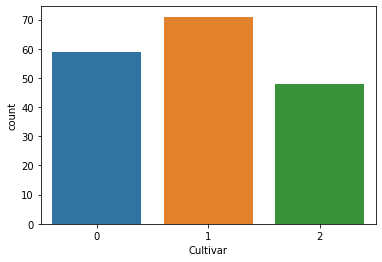

In [6]:
sns.countplot(x='Cultivar', data=dataset)

Bepaal de statistische kerngetallen van de verschillende features en targets. Gebruik hiervoor de *describe* functie (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html). Gebruik de resultaten om na te gaan of er mogelijks ontbrekende waarden, uitschieters of onrealistische waarden zijn.

In [7]:
# statistische vooranalyse
dataset.describe()

,inputs Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,flavanoids,NonflavanoidsPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline,Cultivar
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   inputs Alcohol        178 non-null    float64
 1   MalicAcid             178 non-null    float64
 2   Ash                   178 non-null    float64
 3   AlcalinityOfAsh       178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   TotalPhenols          178 non-null    float64
 6   flavanoids            178 non-null    float64
 7   NonflavanoidsPhenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   ColorIntensity        178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280/OD315           178 non-null    float64
 12  Proline               178 non-null    int64  
 13  Cultivar              178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


### Preprocessing en opsplitsen van de dataset

Splits de dataset in **features en targets**.

In [11]:
# opsplitsen in features en targets
y = dataset['Cultivar'].values
X = dataset.drop(['Cultivar'], axis=1).values

print(y.shape, X.shape)

(178,) (178, 13)


Creëer een **trainingset en een testset**. Zorg dat je 70 wijnen in de test set zitten hebt. Gebruik hiervoor train_test_split functie. Meer info is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [12]:
# aanmaken van een training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=70, random_state=120)

**Normaliseer de dataset**. Zorg er dus voor dat de features op een gelijke schaalverdeling staan. Voor het normaliseren kan gebruik gemaakt worden van de *preprocessing.StandardScaler()*. Meer info over het gebruik ervan is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [13]:
# normaliseren
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) op de training data. 
Kies C=1 als startwaarde. 

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen?

Probeer de performantie van het model te verhogen door het uitvoeren van hyperparameter tuning. Mogelijke hyperparameters zijn:
- Aanpassen van de waarde van C 
- Kiezen van een andere solver
- Regularisatie (penalty) toepassen via L1 of L2 
- Toevoegen van extra (polynomial) features 
- Indien je te maken hebt met niet-gebalanceerde data, dan kan je de class_weigt='balanced' parameter meegeven. Verklaar het effect ervan op de accuracy, recall, precision en de f1-score.


Schrijf de conclusies neer. 



In [14]:
# trainen van het model en hyperparameter tuning +  conclusies
logreg = linear_model.LogisticRegression(C=0.44, solver='liblinear')
model = logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))
print('\n')
print(accuracy_score(y_test, y_pred))

[[22  0  0]
 [ 0 29  1]
 [ 0  0 18]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      0.97      0.98        30
           2       0.95      1.00      0.97        18

    accuracy                           0.99        70
   macro avg       0.98      0.99      0.99        70
weighted avg       0.99      0.99      0.99        70



0.9857142857142858


Text(0, 0.5, 'Accuracy')

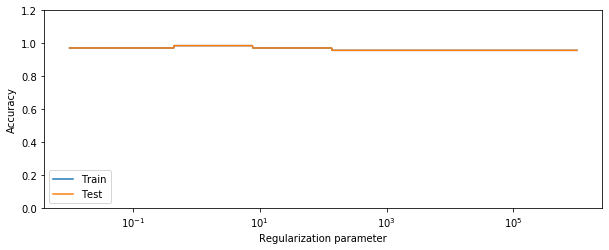

In [15]:
train_acc = []
test_acc = []


cs = np.logspace(-2, 6, 1000)

for c in cs:
    logreg = linear_model.LogisticRegression(C=c, solver='liblinear')
    logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred))
    train_acc.append(accuracy_score(y_test, y_pred))

# Plot r2
f, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.semilogx(cs, train_acc, label='Train')
plt.semilogx(cs, test_acc, label='Test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')

In [16]:
max(test_acc)
cs[test_acc.index(max(test_acc))]

0.4463233926710395

### Voorspel aan de hand van het getrainde model

Voorspel van welke wijnboer een wijn afkomstig is met volgende samenstelling:

inputs Alcohol: 13.52 - 
MalicAcid: 2.05 - 
Ash: 2.20 - 
AlcalinityOfAsh: 17.3 - 
Magnesium: 120 - 
TotalPhenols: 2.60 - 
flavanoids: 3.52 - 
NonflavanoidsPhenols: 0.30 - 
Proanthocyanins: 2.28 - 
ColorIntensity: 7.80 - 
Hue: 0.77 - 
OD280/OD315: 2.90 - 
Proline: 862


Geef ook de overtuiging van het model weer dat de wijn van die bepaalde wijnboer afkomstig is.

In [17]:
# predictie
wine = [[13.52, 2.05, 2.20, 17.3, 120, 2.60, 3.52, 0.30, 2.28, 7.80, 0.77, 2.90, 862]]

# scaler
wine = scaler.transform(wine)
# predict 
pred = logreg.predict(wine)
print(pred)
#probs predict
classification = logreg.predict_proba(wine)
print(classification)

[0]
[[9.99966174e-01 1.22841766e-07 3.37033995e-05]]


Vraag de coëfficiënten van het model op via '.coef_'. Verklaar waarom het aantal coëfficiënten een veelvoud is van het aantal features. Welke features spelen een belangrijke rol om te bepalen of een wijn al dan niet van wijnboer 1 afkomstig is?

In [18]:
# coëfficiënten interpreteren 
model.coef_

array([[ 1.04467752,  0.16456627,  0.64505689, -0.90826653, -0.03911357,
         0.2924864 ,  0.50308355, -0.17845017, -0.14241879, -0.02204284,
         0.24082192,  0.62602893,  1.30750262],
       [-1.28055731, -0.69285711, -0.79797774,  0.56538891, -0.08171916,
         0.07130323,  0.23972581,  0.09713692,  0.32220602, -0.97949127,
         0.52100215,  0.02752276, -1.14285372],
       [ 0.38419114,  0.62315039,  0.23295089,  0.21338276,  0.03408266,
        -0.3640689 , -0.73692394,  0.10825322, -0.19605863,  1.02279427,
        -0.74641789, -0.64168372, -0.12533263]])

### Conclusie
Omdat er X aantal verschillende klasses zijn.
Het alcohol percentage speelt een belangrijke rol in de klassificatie.

## Opdracht 2: Diabetes

Het bestand *diabetes.csv* bevat medische gegevens van meer dan 300 personen waarbij telkens geweten is of de persoon al dan niet diabetes heeft.
Train nu een logic regression model dat op basis van de features een zo goed mogelijke predictie kan doen of iemand al dan niet diabetes heeft.

### Inlezen van de dataset en vooranalyse

In [ ]:
# inlezen van de dataset
dataset = pd.read_csv('diabetes.csv')
dataset.shape

Controleer of de dataset inconsistenties of foute waarden bevat. Gebruik listwise deletion. Dit betekent dat je alle gegevens van een persoon uit de dataset verwijdert van zodra er 1 feature foutief is of ontbreekt.

In [ ]:
# inconsistenties opsporen
dataset[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']] = dataset[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']].replace(0, np.NaN)

In [ ]:
dataset.dropna(inplace=True)
dataset.shape

Bepaal de verdeling van het aantal personen met diabetes ten opzichte van het aantal personen zonder. Is de dataset gebalanceerd?

In [ ]:
# gebalanceerdheid controleren
sns.countplot(x='Outcome', data=dataset)

In [ ]:
# De dataset is niet gebalanceerd, er zijn veer meer gevallen waarbij er geen diabetes is vast gesteld.

Bepaal de statistische kerngetallen van de verschillende features en target. Gebruik hiervoor de *describe* functie.

In [ ]:
#statistische kerngetallen
dataset.describe()

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, square=True, 
            mask=np.zeros_like(dataset.corr(), dtype=np.bool), ax=ax,
           cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [ ]:
sns.pairplot(dataset)

### Preprocessing en opsplitsen van de dataset

Splits de dataset in **features en targets**.

In [ ]:
# Opsplitsen in features en targets
y = dataset.Outcome.values
X = dataset.drop(['Outcome'], axis=1).values

Creëer een **trainingset en een testset**. Zorg dat er 100 patiënten in de testset steken. 

In [ ]:
# training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=30)

**Normaliseer de dataset**. Zorg er dus voor dat de features op een gelijke schaalverdeling staan. Voor het normaliseren kan gebruik gemaakt worden van de *preprocessing.StandardScaler()*. Meer info over het gebruik ervan is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [ ]:
# normalisatie
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier op de training data. Kies C=1 als startwaarde. Mocht de dataset niet gebalanceerd zijn (de ene klasse komt frequenter voor dan de andere klasse) dan kan je bij de creatie van het logistic regression model de parameter class_weight='balanced' meegeven. Meer info: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen? Probeer ook verschillende solvers uit. Bepaal ook telkens de ROC en formuleer conclusies.

Probeer de performantie van de classifier te verhogen door de parameter C te veranderen.

In [ ]:
# hyperparameter tuning
log_reg = linear_model.LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))
print('\n')
print(accuracy_score(y_test, y_pred))

### Bevindingen
De accuracy is met 73% vrij oke.
De F1 score van de niet diabetes patienten ligt hoger doordat de train data meer voorbeelden bevat waarbij de patient geen diabetes heeft.


In [ ]:
train_acc = []
test_acc = []


cs = np.logspace(-2, 6, 1000)

for c in cs:
    logreg = linear_model.LogisticRegression(C=c, solver='liblinear')
    logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred))
    train_acc.append(accuracy_score(y_test, y_pred))

# Plot r2
f, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.semilogx(cs, train_acc, label='Train')
plt.semilogx(cs, test_acc, label='Test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')

### Feature engineering
Creeër hogere orde features door gebruik te maken van *preprocessing.PolynomialFeatures*. Meer info is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Deze functie zal automatische hogere orde features aanmaken door het combineren van de aanwezige features. Heb je bijvoorbeeld drie features, zijnde A, B en C dan worden bij de keuze van een derde orde PolynomialFeatures volgende nieuwe features bijgemaakt:
$A^3, B^3,C^3,A^2B,A^2C,AB^2, B^2C,...$

Experimenteer met verschillende ordes en gebruik de regularisatieparameter C om de performantie te verhogen. Voor indien nodig ook regularisatie uit via een L1 of L2 penalty.

**Opgepast**: het kiezen van een te hoge orde zorgt voor een exponentiële toename aan features waardoor de logistic regression classifier niet meer binnen aanvaardbare tijd getraind kan worden. Advies is om niet hoger te gaan dan 4de orde.

In [ ]:
train_acc = []
test_acc = []


cs = np.logspace(-2, 6, 1000)

graad = 2
poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

for c in cs:
    logreg = linear_model.RidgeClassifier(alpha=c,tol=0.0001,fit_intercept=True, class_weight='balanced')
    logreg.fit(X_train_poly,y_train)
    y_pred = logreg.predict(X_test_poly)
    test_acc.append(accuracy_score(y_test, y_pred))
    train_acc.append(accuracy_score(y_test, y_pred))

# Plot r2
f, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.semilogx(cs, train_acc, label='Train')
plt.semilogx(cs, test_acc, label='Test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')

cs[test_acc.index(max(test_acc))]

In [ ]:
#L2
lregmodel_poly = linear_model.RidgeClassifier(alpha=0.48048704396551317,tol=0.0001,fit_intercept=True, class_weight='balanced')
lregmodel_poly.fit(X_train_poly,y_train)

y_pred = lregmodel_poly.predict(X_test_poly)

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))
print('\n')
print(accuracy_score(y_test, y_pred))

Wat zijn de bevindingen? Formuleer een conclusie. Bespreek hierin de performantie van de getrainde modellen. Wat is de invloed van de parameter C en van het aantal features? Heb je te maken gehad met underfitting en overfitting en hoe heb je dit bepaald? Welke accuracy werd bekomen en hoe zit het met de Recall en Precision? Is de grootte van de trainingset voldoende?

Antwoord: 

### Voorspel aan de hand van het getrainde model

Voorspel of iemand met onderstaande medische parameters als dan niet diabetes heeft. Geef ook de zekerheid van het model weer (kansen dat de patiënt tot een bepaalde klasse behoort).

Pregnancies: 2 -
Glucose: 132 -
BloodPressure: 74 - 
SkinThickness: 20 - 
Insulin: 21 - 
BMI: 24.3 - 
DiabetesPedigreeFunction: 128 - 
Age: 37

In [ ]:
# voorspelling


Standaard zal het model een sample toewijzen aan klasse 1 van zodra de probiliteit boven de threshold van 50% uisteekt. 
Men wil echter de kans op false negatives drastisch verminderen door het aanpassen van de threshold. Welke threshold moet men instellen om ervoor te zorgen dat het model op de test set geen false negatives meer voorspelt en toch nog een zo hoog mogelijke accuraatheid heeft?
Stel het aantal false negatives in functie van de threshold grafisch voor. Bespreek de resultaten.

In [ ]:
# reduceren van het aantal false negatives door de threshold aan te passen




## Opdracht 3. Human resources

Een groot bedrijf probeert te voorspellen of een werknemer binnenkort al dan niet het bedrijf zal verlaten en hoopt zo tijdig te kunnen ingrijpen.
Gebruik logistische regressie op de dataset 'Human_Resources.csv' om een zo accuraat mogelijk model te trainen. 
Tevens wil het bedrijf vooral false negatives vermijden.
Welke zijn de top 3 features die het sterkst bepalen of een werknemer het bedrijf zal verlaten?

De dataset bestaat uit de volgende features:

- satisfaction_level: mate van voldoening op het werk.
- last_evaluationTime: aantal jaar sinds de laatste evaluatie.
- number_project: het aantal projecten die de werknemer op het bedrijf heeft afgewerkt.
- average_montly_hours: het aantal uur die de werknemer gemiddeld per maand aanwezig is op de werkplaats.
- time_spend_company: het aantal jaar in dienst van het bedrijf.
- work_accident: of de werknemer al een werkongeval heeft gehad.
- promotion_last_5years: of de werknemer al dan niet een promotie heeft gehad de afgelopen 5 jaar.
- department: het departement waar de werknemer voor werkt.
- salary: relatief loon (low, medium, high).

De te voorspellen target = left: of de werknemer het bedrijf al dan niet heeft verlaten (0 of 1)

Gebruik one-hot encoding om categorische features om te zetten naar one-hot features.

In [ ]:
dataset = pd.read_csv('Human_Resources.csv')
print('Dimensie van de dataset:',dataset.shape)
dataset.head()

In [ ]:
# uitwerking opdracht human resources
